<a href="https://colab.research.google.com/github/CloudD233/microbiome/blob/main/msp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [56]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [57]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA

In [58]:
# Load the data
data = pd.read_csv('/content/drive/MyDrive/microbiome data/vect_atlas.csv')
sample_id_data = pd.read_csv('/content/drive/MyDrive/microbiome data/sampleID.csv')
taxo_data = pd.read_csv('/content/drive/MyDrive/microbiome data/taxo.csv')


In [59]:
# Check if 'Unnamed: 0' exists and set it as the index if it does
if 'Unnamed: 0' in data.columns:
    data.set_index('Unnamed: 0', inplace=True)
if 'Unnamed: 0' in taxo_data.columns:
    taxo_data.set_index('Unnamed: 0', inplace=True)

In [60]:
# Filter the sample information for T2D and Control groups
t2d_samples = sample_id_data[sample_id_data['Disease'] == 'T2D']['sample.ID']
control_samples = sample_id_data[sample_id_data['Disease'] == 'Healthy']['sample.ID']


In [61]:
# Filter and merge the main dataset with taxonomy for T2D and Control
control_data_filtered = data[control_samples.tolist()]
t2d_data_filtered = data[t2d_samples.tolist()]

control_merged_data = control_data_filtered.merge(taxo_data[['class', 'phylum']], left_index=True, right_index=True)
t2d_merged_data = t2d_data_filtered.merge(taxo_data[['class', 'phylum']], left_index=True, right_index=True)

# Aggregate data at the class level by summing only numeric columns
control_class_abundance = control_merged_data.select_dtypes(include=[float, int]).groupby(control_merged_data['class']).sum().sum(axis=1).sort_values(ascending=False)
t2d_class_abundance = t2d_merged_data.select_dtypes(include=[float, int]).groupby(t2d_merged_data['class']).sum().sum(axis=1).sort_values(ascending=False)


# Convert to relative abundance
control_class_relative_abundance = (control_class_abundance / control_class_abundance.sum()) * 100
t2d_class_relative_abundance = (t2d_class_abundance / t2d_class_abundance.sum()) * 100


In [62]:
# Combine into a DataFrame for plotting
class_data = pd.DataFrame({
    'Control': control_class_relative_abundance,
    'T2D': t2d_class_relative_abundance
}).fillna(0)

In [63]:
stacked_class_data = class_data.T

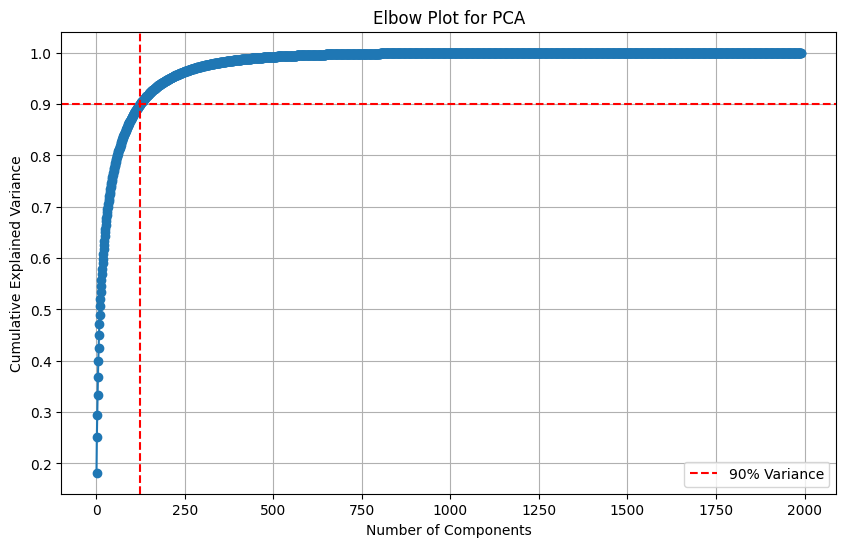

In [64]:
# Assuming 'combined_data' is your combined dataset
pca_full = PCA()
pca_full.fit(combined_data.T)

# Get the explained variance ratios
explained_variance = pca_full.explained_variance_ratio_

# Create the elbow plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance) + 1), np.cumsum(explained_variance), marker='o')
plt.title('Elbow Plot for PCA')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.axhline(y=0.9, color='r', linestyle='--')
plt.axvline(x=np.argmax(np.cumsum(explained_variance) >= 0.9) + 1, color='r', linestyle='--', label='90% Variance')
plt.legend()
plt.grid(True)
plt.show()


In [65]:
# Recompute PCA on the entire combined dataset to obtain the full explained variance ratios
pca_full = PCA()
pca_full.fit(combined_data.T)

# Get the explained variance ratios
explained_variance = pca_full.explained_variance_ratio_

# Calculate the number of components needed to explain at least 90% of the variance
cumulative_variance = np.cumsum(explained_variance)
n_components_90 = np.argmax(cumulative_variance >= 0.9) + 1

n_components_90, cumulative_variance[n_components_90 - 1]


(125, 0.9007419434517838)

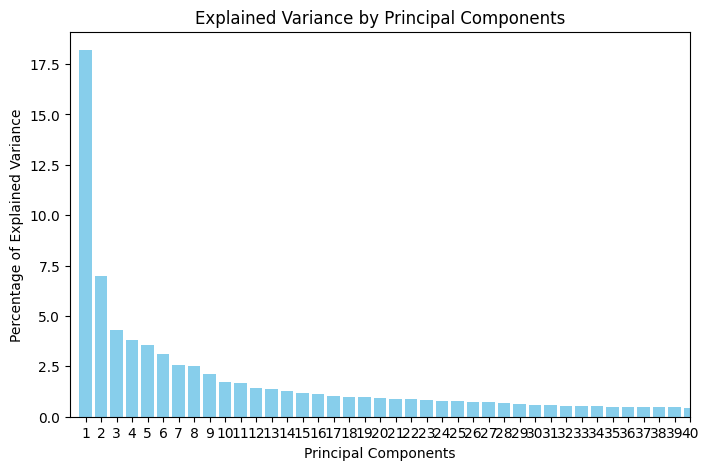

In [66]:
# Attempting to plot the explained variance by principal components again
plt.figure(figsize=(8, 5))
plt.bar(range(1, len(explained_variance) + 1), explained_variance * 100, color='skyblue')
plt.xlabel('Principal Components')
plt.ylabel('Percentage of Explained Variance')
plt.title('Explained Variance by Principal Components')
plt.xticks(range(1, len(explained_variance) + 1))
plt.xlim(0,40)
plt.show()

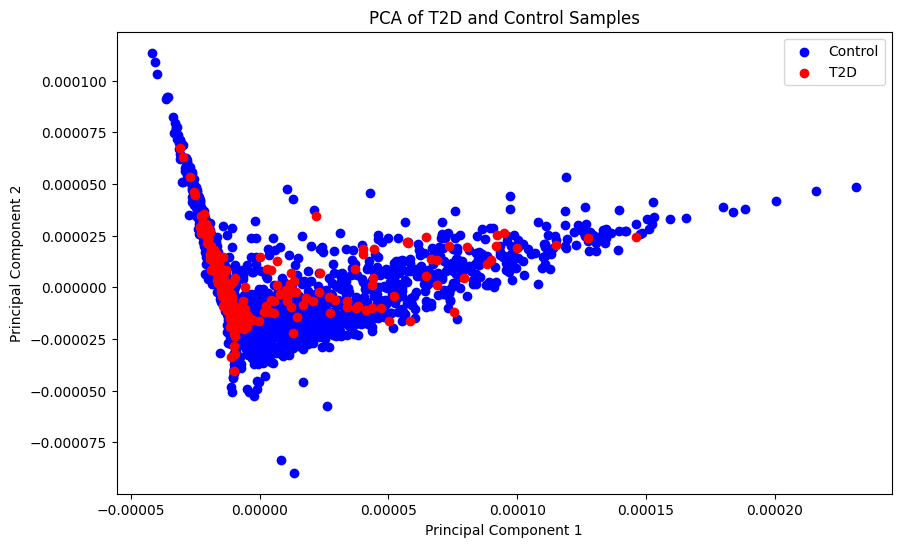

In [67]:
# PCA # Combine T2D and Control data for PCA
combined_data = pd.concat([control_data_filtered, t2d_data_filtered], axis=1)

# Apply PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(combined_data.T)

# Create a DataFrame for the PCA results
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['Group'] = ['Control'] * len(control_samples) + ['T2D'] * len(t2d_samples)

# Plotting
plt.figure(figsize=(10, 6))
for label, color in zip(pca_df['Group'].unique(), ['blue', 'red']):
    condition = pca_df['Group'] == label
    plt.scatter(pca_df.loc[condition, 'PC1'], pca_df.loc[condition, 'PC2'], c=color, label=label)
plt.title('PCA of T2D and Control Samples')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

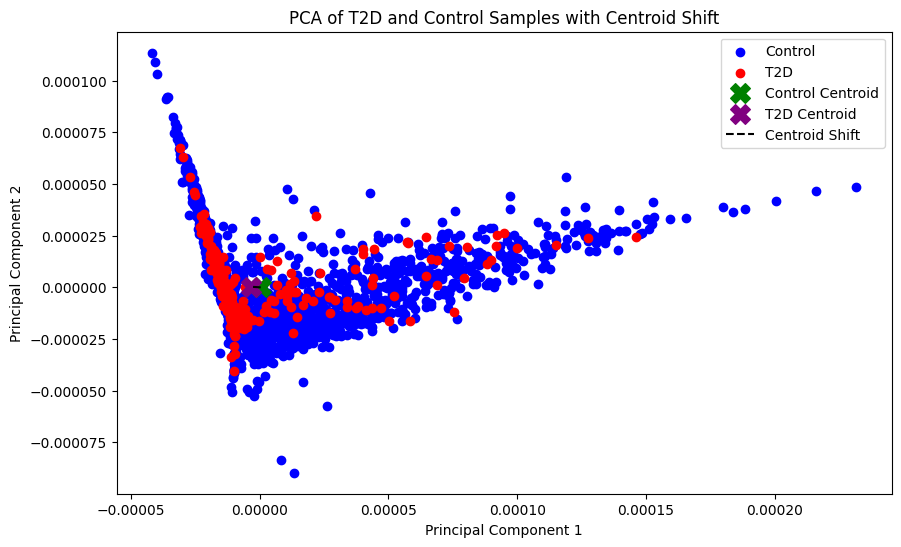

(PC1    3.981466e-07
 PC2   -2.885939e-08
 dtype: float64,
 PC1   -3.497696e-06
 PC2    2.535282e-07
 dtype: float64,
 PC1   -3.895843e-06
 PC2    2.823876e-07
 dtype: float64)

In [68]:
# Calculate the centroids for each group in the PCA space
control_centroid = pca_df[pca_df['Group'] == 'Control'][['PC1', 'PC2']].mean()
t2d_centroid = pca_df[pca_df['Group'] == 'T2D'][['PC1', 'PC2']].mean()

# Calculate the shift between centroids
centroid_shift = t2d_centroid - control_centroid

# Plotting the PCA again with centroids and shift
plt.figure(figsize=(10, 6))
for label, color in zip(pca_df['Group'].unique(), ['blue', 'red']):
    condition = pca_df['Group'] == label
    plt.scatter(pca_df.loc[condition, 'PC1'], pca_df.loc[condition, 'PC2'], c=color, label=label)

# Plot centroids
plt.scatter(control_centroid['PC1'], control_centroid['PC2'], c='green', s=200, marker='X', label='Control Centroid')
plt.scatter(t2d_centroid['PC1'], t2d_centroid['PC2'], c='purple', s=200, marker='X', label='T2D Centroid')

# Draw a line to show the shift
plt.plot([control_centroid['PC1'], t2d_centroid['PC1']], [control_centroid['PC2'], t2d_centroid['PC2']], 'k--', label='Centroid Shift')

plt.title('PCA of T2D and Control Samples with Centroid Shift')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

control_centroid, t2d_centroid, centroid_shift

In [69]:
from sklearn.utils import shuffle

# Function to compute centroids and their shift
def compute_centroid_shift(group_labels):
    centroids = pca_df.groupby(group_labels)[['PC1', 'PC2']].mean()
    return centroids.iloc[1] - centroids.iloc[0]

# Observed shift
observed_shift = compute_centroid_shift(pca_df['Group'])

# Permutation test
n_permutations = 1000
shifts = np.zeros(n_permutations)
for i in range(n_permutations):
    shuffled_labels = shuffle(pca_df['Group'].values)
    shift = compute_centroid_shift(shuffled_labels)
    shifts[i] = np.linalg.norm([shift['PC1'], shift['PC2']])  # Calculate Euclidean distance

# Calculate the p-value
observed_distance = np.linalg.norm([observed_shift['PC1'], observed_shift['PC2']])
p_value = np.sum(shifts >= observed_distance) / n_permutations

p_value

0.039